In [1]:
import importlib
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
import sklearn
from matplotlib import ticker

In [2]:
# again, this only works on startup!
from jax.config import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jacrev, jit, vmap

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load Data

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [9]:
# load committors
qp_du = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [10]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [11]:
def corr_q(e, z_traj, z0, lag=500, sigma=1):
    C = 0
    for z in z_traj:
        q_0 = q(e, z[:-lag], z0, sigma=sigma)
        q_tau = q(e, z[lag:], z0, sigma=sigma)
        # C += jnp.mean(q_0 * q_tau)
        # C -= jnp.mean(q_0**2)
        C += jnp.mean((q_tau - q_0) ** 2)
    return C * -0.5  # want to maximize, so flip sign


def Lagrangian(x, z_traj, z0, lag=500, sigma=1):
    e = x[:-1]
    L = corr_q(e, z_traj, z0, lag=lag, sigma=sigma)
    L -= x[-1] * (jnp.linalg.norm(e) - 1)
    return L


@jit
def q(e, z, z0, sigma=1):
    """Compute the value of the committor for a trajectory z given
    a unit vector e

    z : ndarray of shape (n_frames, n_features)
    z0 : ndarray of shape (n_features,)
    """
    arg = jnp.dot((z - z0), e) / sigma
    return 0.5 * (1 + jax.scipy.special.erf(arg))

In [12]:
offset = 0.05
q_arr = np.concatenate(qp_du)
ts_ids = (q_arr > (0.5 - offset)) & (q_arr < (0.5 + offset))
traj_inds = util.split_indices(cv_trajs)

# Standardize features

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# z_arr = np.hstack((cv_arr, sb_arr, rf161_arr))
# z_trajs = np.split(z_arr, traj_inds, axis=0)
z_arr = cv_arr

scaler = StandardScaler()
z_arr = scaler.fit_transform(z_arr)

z_trajs = np.split(z_arr, traj_inds)
z0 = np.mean(z_arr[ts_ids], axis=0)

## `scipy` optimize (large $\sigma$)

In [15]:
lag = 500
sigma = 10
n_feat = z_arr.shape[1]
e0 = np.ones(n_feat) * jnp.sqrt(1 / n_feat)

## Compute gradient and Hessian of correlation function analytically using Jax `jacrev` and `jacfwd`

In [16]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [17]:
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)

In [18]:
# jit for efficiency
jit_grad = jit(grad_cq, static_argnames=("lag", "sigma"))
jit_hess = jit(hess, static_argnames=("lag", "sigma"))

In [19]:
print(jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma))
print(jit_hess(e0, z_trajs, z0, lag=lag, sigma=sigma)

DeviceArray([-0.05176695, -0.03736626], dtype=float64)

In [20]:
print(g)
print(h)

[-0.05176695 -0.03736626]


## Define constraints so that unit vector is normalized

In [25]:
def cons_f(x):
    return jnp.sum(x * x)


def cons_J(x):
    return 2 * x


def cons_H(x, v):
    return jnp.eye(len(x)) * 2 * v


# constraint that squared norm of x = 1 (use analytical gradient/Hessian)
constraint = scipy.optimize.NonlinearConstraint(cons_f, 1, 1, jac=cons_J, hess=cons_H)

In [26]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0),
    method="trust-constr",
    jac=jit_grad,
    hess=jit_hess,
    constraints=constraint,
    options={"verbose": 2},
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.3227e+00 | 1.00e+00 | 4.99e-01 | 2.22e-16 |
|   2   |   2   |   1   | -2.2422e+00 | 1.00e+00 | 2.55e-01 | 8.60e-01 |
|   3   |   3   |   2   | -1.6656e+00 | 1.00e+00 | 4.41e-03 | 1.17e-01 |
|   4   |   4   |   3   | -1.5556e+00 | 1.00e+00 | 5.44e-04 | 3.06e-03 |
|   5   |   5   |   4   | -1.5526e+00 | 1.00e+00 | 1.11e-06 | 2.62e-06 |
|   6   |   6   |   5   | -1.5526e+00 | 1.00e+00 | 6.23e-13 | 2.15e-12 |

`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 6, CG iterations: 5, optimality: 6.23e-13, constraint violation: 2.15e-12, execution time:  1.3 s.


In [27]:
print(solve_ans)

         cg_niter: 5
     cg_stop_cond: 1
           constr: [array([1.])]
      constr_nfev: [6]
      constr_nhev: [7]
      constr_njev: [6]
   constr_penalty: 1.4225626832155325
 constr_violation: 2.149391775674303e-12
   execution_time: 1.3096985816955566
              fun: -1.5525891054487349
             grad: array([-1.96587292, -0.31901755])
              jac: [array([[1.97417487, 0.32036477]])]
  lagrangian_grad: array([-1.01474384e-13,  6.23057161e-13])
          message: '`gtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 6
             nhev: 6
              nit: 6
            niter: 6
             njev: 6
       optimality: 6.230571614196379e-13
           status: 1
          success: True
        tr_radius: 1.0
                v: [array([0.99579472])]
                x: array([0.98708743, 0.16018239])


In [30]:
def optimize_vector(e0, z_trajs, z0, jac, hess):
    ans = scipy.optimize.minimize(
        corr_q,
        e0,
        args=(z_trajs, z0),
        method="trust-constr",
        jac=jac,
        hess=hess,
        constraints=constraint,
        options={"verbose": 1},
    )
    return ans.x

In [31]:
# randomly choose starting vectors
inits = []
results = []
for i in range(10):
    vec = np.random.normal(size=2)
    init = vec / np.linalg.norm(vec)
    inits.append(init)
    ans = optimize_vector(init, z_trajs, z0, jit_grad, jit_hess)
    results.append(ans)
    print(init, ans)

`gtol` termination condition is satisfied.
Number of iterations: 4, function evaluations: 4, CG iterations: 3, optimality: 2.86e-10, constraint violation: 4.04e-10, execution time: 0.75 s.
[0.9949063  0.10080399] [0.98708743 0.16018239]
`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 7, CG iterations: 5, optimality: 1.49e-09, constraint violation: 2.86e-09, execution time:  1.2 s.
[ 0.94762219 -0.31939348] [0.98708744 0.16018239]
`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 6, CG iterations: 5, optimality: 3.21e-11, constraint violation: 1.00e-10, execution time:  1.3 s.
[0.63647299 0.77129899] [0.98708743 0.16018239]
`gtol` termination condition is satisfied.
Number of iterations: 7, function evaluations: 8, CG iterations: 6, optimality: 3.27e-10, constraint violation: 1.57e-09, execution time:  1.6 s.
[-0.03876042 -0.99924853] [0.98708743 0.16018239]
`gtol` termination condition is satisfied.
Numbe

# Vary $\sigma$

In [32]:
sigma = 1

In [33]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [34]:
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)

In [35]:
print(g)
print(h)

[-1.76641029 -0.76920923]
[[-1.05343892  0.32988227]
 [ 0.32988227 -0.35204941]]


In [36]:
# jit for efficiency
jit_grad = jit(grad_cq, static_argnames=("lag", "sigma"))
jit_hess = jit(hess, static_argnames=("lag", "sigma"))

In [38]:
print(jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma))
print(jit_hess(e0, z_trajs, z0, lag=lag, sigma=sigma))

[-1.76641029 -0.76920923]
[[-1.05343892  0.32988227]
 [ 0.32988227 -0.35204941]]


In [39]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0),
    method="trust-constr",
    jac=jit_grad,
    hess=jit_hess,
    constraints=constraint,
    options={"verbose": 2},
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.3227e+00 | 1.00e+00 | 4.99e-01 | 2.22e-16 |
|   2   |   2   |   1   | -2.2422e+00 | 1.00e+00 | 2.55e-01 | 8.60e-01 |
|   3   |   3   |   2   | -1.6656e+00 | 1.00e+00 | 4.41e-03 | 1.17e-01 |
|   4   |   4   |   3   | -1.5556e+00 | 1.00e+00 | 5.44e-04 | 3.06e-03 |
|   5   |   5   |   4   | -1.5526e+00 | 1.00e+00 | 1.11e-06 | 2.62e-06 |
|   6   |   6   |   5   | -1.5526e+00 | 1.00e+00 | 6.23e-13 | 2.15e-12 |

`gtol` termination condition is satisfied.
Number of iterations: 6, function evaluations: 6, CG iterations: 5, optimality: 6.23e-13, constraint violation: 2.15e-12, execution time:  1.3 s.


In [40]:
print(solve_ans.x)

[0.98708743 0.16018239]


# Use more features

In [41]:
sb_ids = [42, 47, 52, 53, 58, 59]
z_arr = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))

scaler = StandardScaler()
z_arr = scaler.fit_transform(z_arr)

z_trajs = np.split(z_arr, traj_inds)
z0 = np.mean(z_arr[ts_ids], axis=0)

In [42]:
lag = 500
n_feat = z_arr.shape[1]
e0 = np.ones(n_feat) * jnp.sqrt(1 / n_feat)

In [43]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [44]:
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)

In [45]:
print(g)
print(h)

[ 0.26178433 -1.31627006  0.55476321 -1.06480957 -1.52102875 -1.68771687
  0.75917849  0.76758526 -0.20942264]
[[-2.39804329 -0.02034496  0.70113468 -0.4083246  -0.06563467  0.83519473
   0.06923162  0.41697227 -0.19363848]
 [-0.02034496 -2.76425851  1.30084792 -1.33944518 -1.24033409 -1.00729681
   2.02017047  1.66921159 -0.24024601]
 [ 0.70113468  1.30084792 -3.15307765  1.68728974  1.21975348  0.57877554
  -0.34905351 -0.67475386 -0.24930536]
 [-0.4083246  -1.33944518  1.68728974 -2.31278319 -1.47205363 -0.4691838
   0.99482688  1.59676214 -0.16925595]
 [-0.06563467 -1.24033409  1.21975348 -1.47205363 -2.314273   -0.29325679
   2.39979679  2.56975711  0.29245892]
 [ 0.83519473 -1.00729681  0.57877554 -0.4691838  -0.29325679 -2.2175301
   2.37806185  1.34929688  0.23548068]
 [ 0.06923162  2.02017047 -0.34905351  0.99482688  2.39979679  2.37806185
  -2.3073976  -1.56866243  0.97260184]
 [ 0.41697227  1.66921159 -0.67475386  1.59676214  2.56975711  1.34929688
  -1.56866243 -2.54034064 

In [46]:
# jit for efficiency
jit_grad = jit(grad_cq, static_argnames=("lag", "sigma"))
jit_hess = jit(hess, static_argnames=("lag", "sigma"))

In [48]:
print(jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma))
print(jit_hess(e0, z_trajs, z0, lag=lag, sigma=sigma))

[ 0.26178433 -1.31627006  0.55476321 -1.06480957 -1.52102875 -1.68771687
  0.75917849  0.76758526 -0.20942264]
[[-2.39804329 -0.02034496  0.70113468 -0.4083246  -0.06563467  0.83519473
   0.06923162  0.41697227 -0.19363848]
 [-0.02034496 -2.76425851  1.30084792 -1.33944518 -1.24033409 -1.00729681
   2.02017047  1.66921159 -0.24024601]
 [ 0.70113468  1.30084792 -3.15307765  1.68728974  1.21975348  0.57877554
  -0.34905351 -0.67475386 -0.24930536]
 [-0.4083246  -1.33944518  1.68728974 -2.31278319 -1.47205363 -0.4691838
   0.99482688  1.59676214 -0.16925595]
 [-0.06563467 -1.24033409  1.21975348 -1.47205363 -2.314273   -0.29325679
   2.39979679  2.56975711  0.29245892]
 [ 0.83519473 -1.00729681  0.57877554 -0.4691838  -0.29325679 -2.2175301
   2.37806185  1.34929688  0.23548068]
 [ 0.06923162  2.02017047 -0.34905351  0.99482688  2.39979679  2.37806185
  -2.3073976  -1.56866243  0.97260184]
 [ 0.41697227  1.66921159 -0.67475386  1.59676214  2.56975711  1.34929688
  -1.56866243 -2.54034064 

In [49]:
solve_ans = scipy.optimize.minimize(
    corr_q,
    e0,
    args=(z_trajs, z0),
    method="trust-constr",
    jac=jit_grad,
    hess=jit_hess,
    constraints=constraint,
    options={"verbose": 2},
)
print(solve_ans.x)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -1.7099e+00 | 1.00e+00 | 1.30e+00 | 2.22e-16 |
|   2   |   2   |   1   | -4.6191e+00 | 1.00e+00 | 1.76e+00 | 1.00e+00 |
|   3   |   3   |   2   | -5.2552e+00 | 1.00e+00 | 4.10e+00 | 1.00e+00 |
|   4   |   4   |   3   | -5.3256e+00 | 1.00e+00 | 5.14e+00 | 1.00e+00 |
|   5   |   5   |   4   | -7.7410e+00 | 1.00e+00 | 4.77e+00 | 1.00e+00 |
|   6   |   6   |   6   | -7.7410e+00 | 5.00e-01 | 4.77e+00 | 1.00e+00 |
|   7   |   7   |   7   | -7.2681e+00 | 5.00e-01 | 2.34e+00 | 2.50e-01 |
|   8   |   8   |  10   | -8.0134e+00 | 3.50e+00 | 5.09e+00 | 2.50e-01 |
|   9   |   9   |  14   | -9.2964e+00 | 4.82e+00 | 2.94e+00 | 4.75e-01 |
|  10   |  10   |  18   | -8.0994e+00 | 4.82e+00 | 2.17e-01 | 1.10e-01 |
|  11   |  11   |  21   | -7.5870e+00 | 4.82e+00 | 3.71e-02 | 3.74e-03 |
|  12   |  12   |  24   | -7.5685e+00 | 4.82e+00 | 

In [50]:
# randomly choose starting vectors
inits = []
results = []
for i in range(20):
    vec = np.random.normal(size=n_feat)
    init = vec / np.linalg.norm(vec)
    inits.append(init)
    ans = optimize_vector(init, z_trajs, z0, jit_grad, jit_hess)
    results.append(ans)
    print(init, ans)

`xtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 24, CG iterations: 67, optimality: 1.16e-08, constraint violation: 2.22e-16, execution time:  5.4 s.
[ 0.16410269 -0.1822989   0.68963155 -0.54148088  0.07293063 -0.01072593
  0.17738128  0.36582722  0.01779301] [ 0.03987754  0.02096064  0.53049233 -0.08751875 -0.46283053 -0.44181732
 -0.24897896 -0.08127903  0.48049697]
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 26, CG iterations: 58, optimality: 9.30e-09, constraint violation: 2.22e-16, execution time:  5.8 s.
[ 0.6424748   0.41964353 -0.06781328 -0.55563754 -0.055218   -0.11448375
  0.17412761  0.08167724 -0.21129735] [ 0.03987754  0.02096064  0.53049233 -0.08751875 -0.46283053 -0.44181732
 -0.24897896 -0.08127903  0.48049697]
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 20, CG iterations: 48, optimality: 5.09e-10, constraint violation: 1.11e-16, exec

In [53]:
best = results[13]

In [55]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [59]:
names = []
names.append(feature_names[0])
names.append(feature_names[1])
for i in sb_ids:
    names.append(feature_names[i - 30 + 2])
names.append(feature_names[33])

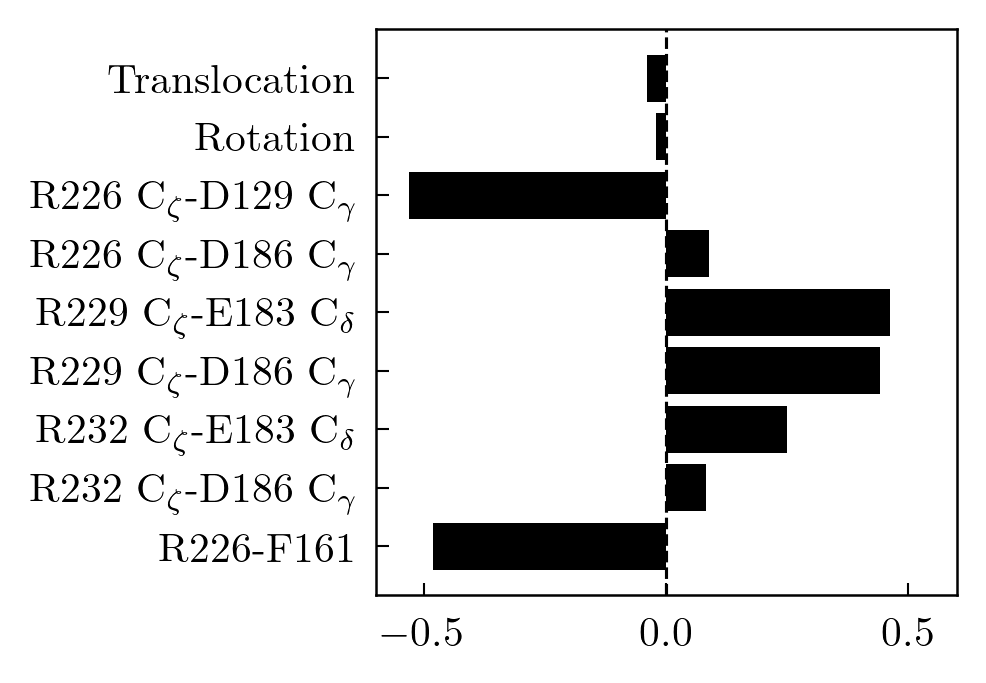

In [64]:
f = plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = f.gca()

ax.barh(np.arange(n_feat), best, color='black', zorder=5)
ax.axvline(color='black', zorder=0, ls='--')
ax.set_xlim([-0.6, 0.6])
# ax.set_xticks([], labels=[])
ax.set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')
# sns.despine(fig=f, top=True, left=False, right=True, bottom=True)

ax.invert_yaxis()

## different sigma

In [65]:
def corr_q(e, z_traj, z0, lag=500, sigma=10):
    C = 0
    for z in z_traj:
        q_0 = q(e, z[:-lag], z0, sigma=sigma)
        q_tau = q(e, z[lag:], z0, sigma=sigma)
        # C += jnp.mean(q_0 * q_tau)
        # C -= jnp.mean(q_0**2)
        C += jnp.mean((q_tau - q_0) ** 2)
    return C * -0.5  # want to maximize, so flip sign

In [66]:
grad_cq = jacrev(corr_q)
hess = jacfwd(grad_cq)

In [69]:
sigma = 10
g = grad_cq(e0, z_trajs, z0, lag=lag, sigma=sigma)
h = hess(e0, z_trajs, z0, lag=lag, sigma=sigma)

In [70]:
print(g)
print(h)

[-0.0193998  -0.00241762 -0.0531579  -0.02657173 -0.12182686 -0.11279404
 -0.10816322 -0.05277737 -0.06730925]
[[-5.34973867e-02 -2.62986045e-03  1.74474632e-02 -3.15813661e-03
  -1.66904818e-03  1.56816927e-02 -6.65675202e-05  9.05055464e-03
   7.19443122e-03]
 [-2.62986045e-03 -3.72308923e-02  9.77334534e-03 -1.46092357e-03
   6.22777445e-04  3.44681823e-03  7.88179737e-03  2.82987509e-03
   2.52835515e-03]
 [ 1.74474632e-02  9.77334534e-03 -1.14952568e-01  3.26983490e-02
   1.84593934e-02  1.10430875e-02  1.45459120e-02  6.90213382e-03
  -4.24728685e-02]
 [-3.15813661e-03 -1.46092357e-03  3.26983490e-02 -6.19048927e-02
  -1.18317932e-02 -1.95677596e-03 -4.07869419e-03  1.08696729e-02
   4.68182421e-03]
 [-1.66904818e-03  6.22777445e-04  1.84593934e-02 -1.18317932e-02
  -1.31933995e-01 -7.06006559e-02 -4.46304190e-02  3.04470435e-03
   1.02700762e-02]
 [ 1.56816927e-02  3.44681823e-03  1.10430875e-02 -1.95677596e-03
  -7.06006559e-02 -1.52603261e-01 -9.58610054e-03 -1.55708202e-02
  

In [71]:
# jit for efficiency
jit_grad = jit(grad_cq, static_argnames=("lag", "sigma"))
jit_hess = jit(hess, static_argnames=("lag", "sigma"))

In [72]:
print(jit_grad(e0, z_trajs, z0, lag=lag, sigma=sigma))
print(jit_hess(e0, z_trajs, z0, lag=lag, sigma=sigma))

[-0.0193998  -0.00241762 -0.0531579  -0.02657173 -0.12182686 -0.11279404
 -0.10816322 -0.05277737 -0.06730925]
[[-5.34973867e-02 -2.62986045e-03  1.74474632e-02 -3.15813661e-03
  -1.66904818e-03  1.56816927e-02 -6.65675202e-05  9.05055464e-03
   7.19443122e-03]
 [-2.62986045e-03 -3.72308923e-02  9.77334534e-03 -1.46092357e-03
   6.22777445e-04  3.44681823e-03  7.88179737e-03  2.82987509e-03
   2.52835515e-03]
 [ 1.74474632e-02  9.77334534e-03 -1.14952568e-01  3.26983490e-02
   1.84593934e-02  1.10430875e-02  1.45459120e-02  6.90213382e-03
  -4.24728685e-02]
 [-3.15813661e-03 -1.46092357e-03  3.26983490e-02 -6.19048927e-02
  -1.18317932e-02 -1.95677596e-03 -4.07869419e-03  1.08696729e-02
   4.68182421e-03]
 [-1.66904818e-03  6.22777445e-04  1.84593934e-02 -1.18317932e-02
  -1.31933995e-01 -7.06006559e-02 -4.46304190e-02  3.04470435e-03
   1.02700762e-02]
 [ 1.56816927e-02  3.44681823e-03  1.10430875e-02 -1.95677596e-03
  -7.06006559e-02 -1.52603261e-01 -9.58610054e-03 -1.55708202e-02
  

In [77]:
# randomly choose starting vectors
def optimize_vector(e0, z_trajs, z0, jac, hess):
    ans = scipy.optimize.minimize(
        corr_q,
        e0,
        args=(z_trajs, z0),
        method="trust-constr",
        jac=jac,
        hess=hess,
        constraints=constraint,
        options={"verbose": 1},
    )
    return ans.x, ans.optimality


def try_multiple(n_replicas):
    inits = []
    results = []
    opts = []
    for i in range(n_replicas):
        vec = np.random.normal(size=n_feat)
        init = vec / np.linalg.norm(vec)
        inits.append(init)
        ans, opt = optimize_vector(init, z_trajs, z0, jit_grad, jit_hess)
        results.append(ans)
        opts.append(opt)
        print(ans, opt)
    return inits, results, opts

In [86]:
starting_vecs = []
ending_vecs = []
opts = []
for i in range(20):
    vec = np.random.normal(size=n_feat)
    init = vec / np.linalg.norm(vec)
    starting_vecs.append(init)
    ans, opt = optimize_vector(init, z_trajs, z0, jit_grad, jit_hess)
    ending_vecs.append(ans)
    opts.append(opt)
    print(ans, opt)

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 32, CG iterations: 22, optimality: 6.74e-09, constraint violation: 4.60e-11, execution time:  6.3 s.
[-0.00470817  0.03497334 -0.03687715 -0.08284775 -0.61317086 -0.60116396
 -0.45044417 -0.20579001 -0.08890976] 6.735184914993808e-09
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 48, CG iterations: 31, optimality: 1.40e-09, constraint violation: 9.46e-14, execution time:  9.3 s.
[-0.00470815  0.03497336 -0.03687716 -0.08284775 -0.61317086 -0.60116395
 -0.45044417 -0.20579    -0.08890977] 1.3991248437594805e-09
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 37, CG iterations: 26, optimality: 6.16e-09, constraint violation: 3.18e-14, execution time:  7.3 s.
[-0.00470814  0.03497337 -0.03687711 -0.08284777 -0.61317087 -0.60116395
 -0.45044417 -0.20578999 -0.08890973] 6.155971440935382e-09
`gtol` termination condi

[-0.22694946  0.6604244   0.20995478 -0.02814613  0.31428875  0.01737413
 -0.5331652   0.22611585  0.18162479]
[ 0.00470815 -0.03497336  0.03687715  0.08284776  0.61317086  0.60116394
  0.45044418  0.20579001  0.08890976]


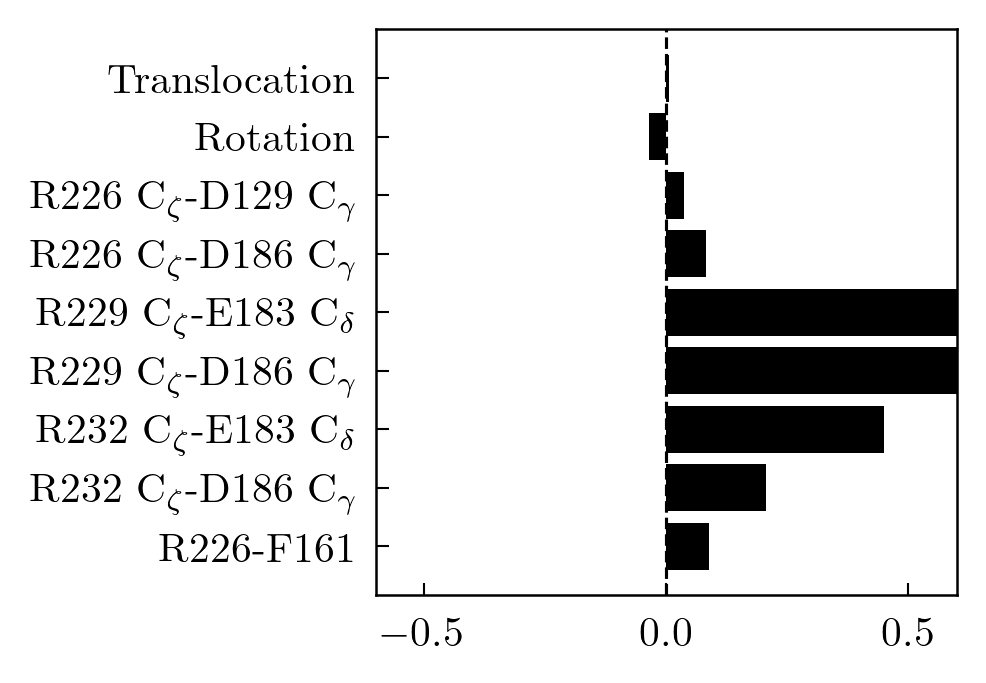

In [87]:
best_id = np.argmin(opts)
print(starting_vecs[best_id])
print(ending_vecs[best_id])

f = plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = f.gca()

ax.barh(np.arange(n_feat), ending_vecs[best_id], color='black', zorder=5)
ax.axvline(color='black', zorder=0, ls='--')
ax.set_xlim([-0.6, 0.6])
ax.set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')

ax.invert_yaxis()